In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from ba_datasets import LogMelDataset, load_dataset
from models import XVector
from tools import *

device = "cuda:1" if torch.cuda.is_available() else "cpu"

In [2]:
import os
from transformers import HubertModel, Wav2Vec2FeatureExtractor

os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

hubert_name = "facebook/hubert-large-ls960-ft"
hubert = HubertModel.from_pretrained(hubert_name).to(device).eval()  # type: ignore
hubert_fe = Wav2Vec2FeatureExtractor.from_pretrained(hubert_name)
hubert_sr = 16000

centroids = pd.read_parquet("xvector_centroids.parquet")
centroids_dict = {x["label"]: x["emb"] for x in centroids.to_dict("records")}

In [3]:
from glob import glob
import torchaudio


def to_16ms(x, target_length):
    # scale time dimension by 1.25 (50 Hz -> 62.5 Hz)
    x_up = F.interpolate(
        x.transpose(-1, -2),
        scale_factor=(target_length + 1) / x.shape[-2],
        mode="linear",
        align_corners=False,
    )[:, :, :target_length]
    return x_up.transpose(-1, -2)


def prepare_wav(wav, sr):
    wav = wav.to(device)
    if wav.ndim > 1:
        wav = torch.mean(wav, dim=0, keepdim=True)  # to mono
    if sr != hubert_sr:
        wav = torchaudio.functional.resample(wav, sr, hubert_sr)
        sr = hubert_sr
    logmel = to_logmelspec(wav, sr)
    f0 = extract_f0_torchcrepe(wav)
    # plt.plot(f0.cpu().numpy()[0])

    # HuBERT runs at ~20ms stride; we’ll resample to 16ms by linear interpolation later
    inputs = hubert_fe(
        wav.cpu().numpy(), sampling_rate=hubert_sr, return_tensors="pt", padding=True
    )
    with torch.no_grad():
        out = hubert(inputs.input_values.to(device))  # last hidden state (B,T_h,D)
        H = out.last_hidden_state.squeeze(0)

    H = to_16ms(H.unsqueeze(0), f0.shape[-1]).squeeze(0)  # (T_h,D)
    H, f0, logmel = H.cpu(), f0.cpu(), logmel.cpu()
    return H, f0, logmel


audio_files = sorted(glob("VOC_JP/**/*.ogg", recursive=True))
audio_labels = [os.path.basename(os.path.dirname(f)) for f in audio_files]
wav, sr = torchaudio.load(audio_files[0])
H, f0, logmel = prepare_wav(wav, sr)
print(H.shape, f0.shape, logmel.shape)
print(H.device, f0.device, logmel.device)

/home/lyc/work/ba_voice/.venv/lib/python3.13/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/lyc/work/ba_voice/.venv/lib/python3.13/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3

torch.Size([114, 1024]) torch.Size([1, 114]) torch.Size([1, 114, 80])
cpu cpu cpu


In [40]:
from models import Content2MelAttn
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
vocoder.to(device).eval()  # type: ignore

model_vc = Content2MelAttn(
    content_dim=1024,
    spk_dim=256,
    d_model=512,
    nhead=8,
    nlayers=16,
    ff_mult=8,
    n_mels=80,
    dropout=0.1,
).to(device)
model_vc.eval()


def convert_voice(wav_path: str, target_spk: str):
    wav, sr = torchaudio.load(wav_path)
    wav = torch.mean(wav, dim=0, keepdim=True)  # to mono
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    sr = 16000

    H, f0, _ = prepare_wav(wav, sr)  # we won't use source mel here
    V = centroids_dict[target_spk]  # your centroid, (256,)
    V = torch.tensor(np.array(V))
    print(H.shape, f0.shape, V.shape)
    with torch.no_grad():
        pred_mel = model_vc(
            H.unsqueeze(0).to(device),
            f0.to(device),
            V.unsqueeze(0).to(device),
        )[
            0
        ]  # (T,80)
        y = vocoder(pred_mel.unsqueeze(0)).squeeze(0).cpu().numpy()
    return y, pred_mel.cpu()

VOC_JP/JP_Airi/airi_cafe_act_1.ogg -> JP_Yuuka
torch.Size([203, 1024]) torch.Size([1, 203]) torch.Size([256])
torch.Size([203, 1024]) torch.Size([1, 203]) torch.Size([256])


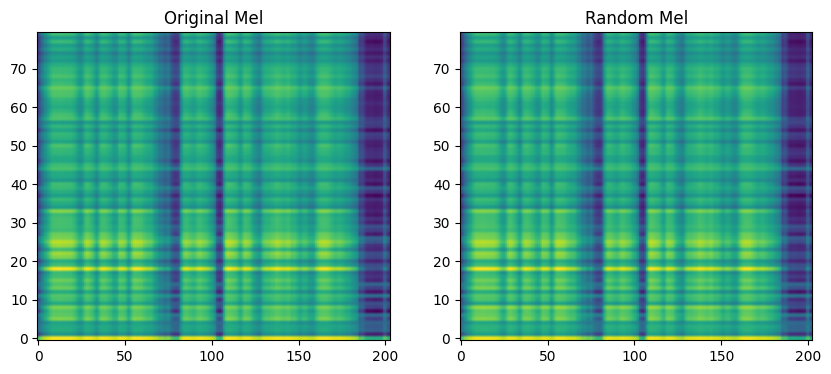

In [41]:
model_vc.load_state_dict(torch.load("content2mel_selfrec.pt", map_location=device))

sorted(audio_files)
audio_labels[0]
import random

idx = 1
rnd = random.randint(0, len(audio_files) - 1)
rnd = 19160
print(audio_files[idx], "->", audio_labels[rnd])
y, mel = convert_voice(audio_files[idx], audio_labels[idx])
y2, mel2 = convert_voice(audio_files[idx], audio_labels[rnd])
# plt.imshow(mel.transpose(0, 1), aspect="auto", origin="lower")
# plt.imshow(mel2.transpose(0, 1), aspect="auto", origin="lower")
# plot mel and mel2 together
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(mel.transpose(0, 1), aspect="auto", origin="lower")
plt.title("Original Mel")
plt.subplot(1, 2, 2)
plt.imshow(mel2.transpose(0, 1), aspect="auto", origin="lower")
plt.title("Random Mel")
plt.show()

display_audio(audio_files[idx], 44100)
display_audio(y, 16000)
display_audio(y2, 16000)